# AlgebraicPetri Demo

This notebook demonstrates the capabilities of AlgebraicPetri along with some interop tools with Semagrams (especially applied to the epidemiology use-case). 

There is a significant amount of code at the beginning of this notebook, a good portion of which will be included in the next release of AlgebraicPetri, either as core featues or in the `examples` section.

In [1]:
""" This module contains the stratification tooling built using the 
    AlgebraicPetri model composition framework
"""

module ModelStratify

# The available functions, all have necessary docstrings
export dem_strat, diff_strat, diff_petri, dem_petri, stratify,
       serialize, deserialize, save_petri, save_json, save_model,
       ScaleGraph, locations, scale_locs, ScaleGraphSchema,
       dem_strat_uwd
using AlgebraicPetri
using Semagrams

using Catlab
using Catlab.CategoricalAlgebra
using Catlab.Graphs.BasicGraphs
using Catlab.Graphs
using Catlab.Graphs.BasicGraphs: Graph, TheoryGraph
using Catlab.WiringDiagrams
using Catlab.Programs
using Catlab.Graphics
using Catlab.Graphics.Graphviz: run_graphviz
using Catlab.Graphics.GraphvizGraphs

function locations(pn::AbstractPetriNet, lsd::LocatedSemagramData; kw...)
  blocs = lsd.boxlocs
  sclocs = scale_locs(collect(values(lsd.boxlocs)); kw...)
  for (i,k) in enumerate(keys(blocs))
    blocs[k] = sclocs[i]
  end

  boxes = sort(collect(lsd.sg.boxes); by=first)
  locs = Dict{Symbol, Vector{Tuple{Float64, Float64}}}(:T=>[], :S=>[])

  for (id, b) in boxes
    push!(locs[b.ty], locs[id])
  end
  locs
end

function locations(pn::Union{LabelledReactionNet, LabelledPetriNet},
                   lsd::LocatedSemagramData; kw...)
  blocs = lsd.boxlocs
  sclocs = scale_locs(collect(values(lsd.boxlocs)); kw...)
  for (i,k) in enumerate(keys(blocs))
    blocs[k] = sclocs[i]
  end

  boxes = sort(collect(lsd.sg.boxes); by=first)
  t_boxes = filter(b -> b[2].ty == :T, boxes)
  s_boxes = filter(b -> b[2].ty == :S, boxes)

  t_label2id = Dict(b[2].weights[:tname]=>b[1] for b in t_boxes)
  s_label2id = Dict(b[2].weights[:sname]=>b[1] for b in s_boxes)

  Dict(:T=>[blocs[t_label2id["$t"]] for t in tnames(pn)],
       :S=>[blocs[s_label2id["$s"]] for s in snames(pn)])
end

function scale_locs(locs::Vector{Tuple{Float64, Float64}}; scale=72 * 2)
  # Scale the locs
  locs = map(v->v ./ scale, locs)

  # Rotate over y-axis
  y_mean = (maximum(last.(locs)) + minimum(last.(locs))) / 2.0
  locs = map(locs) do l
    (1,-1) .* (l .- (0, y_mean))
  end

  # Shift back to 0,0
  shift = (minimum(first.(locs)), minimum(last.(locs)))
  map(v-> v .- shift, locs)
end



import Base.:+
import Base.convert
Base.convert(::Type{Symbol}, str::String) = Symbol(str)

function Base.setindex!(pn::LabelledReactionNet, val, label)
  if label ∈ tnames(pn)
    pn[first(incident(pn, label, :tname)), :rate] = val
  elseif label ∈ snames(pn)
    pn[first(incident(pn, label, :sname)), :concentration] = val
  else
    error("$label is not a valid state or transition name")
  end
end
function Base.getindex(pn::LabelledReactionNet, label)
  if label ∈ tnames(pn)
    pn[first(incident(pn, label, :tname)), :rate]
  elseif label ∈ snames(pn)
    pn[first(incident(pn, label, :sname)), :concentration]
  else
    error("$label is not a valid state or transition name")
  end
end
Base.setindex!(pn::LabelledReactionNet, val, label::Symbol, city) =
  setindex!(pn, val, Symbol(label, "@", city))

Base.getindex(pn::LabelledReactionNet, label::Symbol, city) =
  getindex(pn, Symbol(label, "@", city))


# Define helper functions for defining the two types of
# reactions in an epidemiology Model. Either a state
# spontaneously changes, or one state causes another to change

##################
# Weighted Graph #
##################

@present TheoryScaleGraph <: TheoryGraph begin
  Scale::Data
  Label::Data
  crossexposure::Attr(E, Scale)
  pop_frac::Attr(V, Scale)
  exposure::Attr(V, Scale)
  node_label::Attr(V, Label)
end

@semagramschema ScaleGraphSchema(TheoryScaleGraph) begin
  @box V Circle label = :node_label
  @wire E(src,tgt)
  @data Scale Numeric
  @data Label Stringlike
end;

const AbstractScaleGraph = AbstractACSetType(TheoryScaleGraph)
const ScaleGraph = ACSetType(TheoryScaleGraph, index=[:src,:tgt])

iscale(s::ScaleGraph, i::Int) = s[i, :exposure]
cscale(s::ScaleGraph, i::Int) = s[i, :pop_frac]
escale(s::ScaleGraph, i::Int) = s[i, :crossexposure]
nlabel(s::ScaleGraph, i::Int) = s[i, :node_label]
infection_scale(s::ScaleGraph) =
  1/sum(vcat([cscale(s, src(s, e))*cscale(s, tgt(s,e))*escale(s,e)
               for e in 1:ne(s)],
             [iscale(s,v) * cscale(s,v)^2 for v in 1:nv(s)]...))

nlabels(s::ScaleGraph) = s[:node_label]

matching_states(pattern, states) = collect(filter(s->(string(pattern)==first(split(string(s), "@"))), states))

function connection(conn_petri::LabelledReactionNet, m1::LabelledReactionNet,
                    m2::LabelledReactionNet, ind1, ind2, rate_fact, cscale1, cscale2)
  new_conn = copy(conn_petri)
  set_subpart!(new_conn, :sname, vcat(subpart(m1, :sname), subpart(m2, :sname)))
  set_subpart!(new_conn, :concentration, vcat(subpart(m1, :concentration), subpart(m2, :concentration)))
  set_subpart!(new_conn, :tname, [Symbol("$(name)_$(ind1)_$(ind2)") for name in subpart(conn_petri, :tname)])

  set_subpart!(new_conn, :rate, subpart(conn_petri,:rate) .* rate_fact)
  Open(new_conn, subpart(m1, :sname)[1:ns(m1)], subpart(m2, :sname)[1:ns(m2)])
end

# Creates a UWD which provides the composition pattern of the stratification
function cross_uwd(connections::Tuple{Union{LabelledPetriNet, LabelledReactionNet},
                                      Union{Graph, ScaleGraph}}...)
    rel = RelationDiagram{Symbol}(0)

    # Add populations
    g = first(connections)[2]
    juncs = add_junctions!(rel, nv(g), variable=[Symbol("pop$i") for i in 1:nv(g)])

    # Add epidemiology model boxes
    boxes = add_parts!(rel, :Box, nv(g), name=[Symbol("ep$i") for i in 1:nv(g)])
    add_parts!(rel, :Port, nv(g), junction=juncs, box=boxes)

    for conn in 1:length(connections)
      g = connections[conn][2]
      srcs = subpart(g, :src)
      tgts = subpart(g, :tgt)
      # Add cross boxes
      boxes = add_parts!(rel, :Box, ne(g), name=[Symbol("cross_$(conn)_$(srcs[i])_$(tgts[i])") for i in 1:ne(g)])
      add_parts!(rel, :Port, ne(g), junction=srcs, box=boxes)
      add_parts!(rel, :Port, ne(g), junction=tgts, box=boxes)
    end
    rel
end

# Creates a copy of a petrinet with indices added to the names to create
# uniquely named states
function index_petri(model::LabelledReactionNet, ind, rscale::Number, cscale::Number; scaled_transitions::Union{Nothing, Array{Symbol}}=nothing)
  new_petri = copy(model)
  snames = subpart(model, :sname)
  tnames = subpart(model, :tname)

  rscales = [(isnothing(scaled_transitions) ||
              new_petri[i, :tname] ∈ scaled_transitions) ? rscale : 1
              for i in 1:nparts(new_petri, :T)]

  set_subpart!(new_petri, :sname, [Symbol("$(name)@$ind") for name in snames])
  set_subpart!(new_petri, :tname, [Symbol("$(name)@$ind") for name in tnames])

  set_subpart!(new_petri, :rate, rscales .* subpart(new_petri, :rate))
  set_subpart!(new_petri, :concentration, cscale*subpart(new_petri, :concentration))
  Open(new_petri, subpart(new_petri, :sname))
end

function dem_petri(model::LabelledReactionNet{R,C}, transitions::Vector) where {R, C}
  states1 = subpart(model, :sname)
  concs = concentrations(model)
  transitions = [(Symbol("crx_$(sus)′_$(inf)")=>rate)=>((Symbol(sus, "′"), inf)=>(Symbol(exp, "′"), inf))
                 for (((sus, inf), exp), rate) in transitions]

  states = vcat([state=>concs[state] for state in states1],
                [Symbol("$(state)′")=>concs[state] for state in states1])
  LabelledReactionNet{R, C}(states, transitions...)

end

infection(model, t) = begin
  inp, otp = (inputs(model, t), outputs(model, t))
  (length(inp) == 2 && length(otp) == 2) || return nothing
  inf_ind = findfirst(op -> op ∈ inp, otp)
  inf = otp[inf_ind]
  isnothing(inf) && return nothing
  exp_ind = 3 - inf_ind
  exp = otp[exp_ind]
  sus = inp[3 - findfirst(ip -> ip == inf, inp)]
  return ((sname(model, sus), sname(model, inf))=>sname(model, exp))=>rate(model, t)
end

infections(model) = [infection(model, t) for t in 1:nt(model)]

function dem_petri(model::LabelledReactionNet{R,C}) where {R,C}
  transitions = infections(model)
  filter!(x -> !isnothing(x), transitions)
  dem_petri(model, transitions)
end

function stratify(model::LabelledReactionNet, connections::Tuple{LabelledReactionNet, ScaleGraph}...; scaled_transitions::Union{Nothing, Array{Symbol}}=nothing)
    conn_uwd = cross_uwd(connections...)

    # Calls diffusion_petri for each edge as (src, tgt)
    g = first(connections)[2]
    inf_scale = infection_scale(g)
    scaled_transitions = tnames(model)[.!(isnothing.(infections(model)))]
    ep_map = Dict{Symbol, OpenLabelledReactionNet}(
                 [Symbol("ep$i") =>
                  index_petri(model, nlabel(g,i), inf_scale * iscale(g,i), cscale(g,i);
                              scaled_transitions=scaled_transitions) for i in 1:nv(g)])

    for conn in 1:length(connections)
      p = connections[conn][1]
      g = connections[conn][2]
      srcs = subpart(g, :src)
      tgts = subpart(g, :tgt)
      for i in 1:ne(g)
        ep_map[Symbol("cross_$(conn)_$(srcs[i])_$(tgts[i])")] =
              connection(p, apex(ep_map[Symbol("ep$(srcs[i])")]),
                            apex(ep_map[Symbol("ep$(tgts[i])")]),
                            srcs[i], tgts[i], inf_scale*escale(g,i),
                            cscale(g, srcs[i]), cscale(g, tgts[i]))
      end
    end

    apex(oapply(conn_uwd, ep_map))
end

function strat_uwd(model::LabelledReactionNet, connections::Tuple{LabelledReactionNet, ScaleGraph}...; scaled_transitions::Union{Nothing, Array{Symbol}}=nothing)
    conn_uwd = cross_uwd(connections...)

    # Calls diffusion_petri for each edge as (src, tgt)
    g = first(connections)[2]
    inf_scale = infection_scale(g)
    scaled_transitions = tnames(model)[.!(isnothing.(infections(model)))]
    ep_map = Dict{Symbol, OpenLabelledReactionNet}(
                 [Symbol("ep$i") =>
                  index_petri(model, nlabel(g,i), inf_scale * iscale(g,i), cscale(g,i);
                              scaled_transitions=scaled_transitions) for i in 1:nv(g)])

    for conn in 1:length(connections)
      p = connections[conn][1]
      g = connections[conn][2]
      srcs = subpart(g, :src)
      tgts = subpart(g, :tgt)
      for i in 1:ne(g)
        ep_map[Symbol("cross_$(conn)_$(srcs[i])_$(tgts[i])")] =
              connection(p, apex(ep_map[Symbol("ep$(srcs[i])")]),
                            apex(ep_map[Symbol("ep$(tgts[i])")]),
                            srcs[i], tgts[i], inf_scale*escale(g,i),
                            cscale(g, srcs[i]), cscale(g, tgts[i]))
      end
    end

    conn_uwd, ep_map
end

""" dem_strat(epi_model, connection_graph, sus_state, exp_state, inf_states)
  This function takes in a LabelledPetriNet and a graph which describes
  infection connections between populations. It also takes in the symbol used
  for susceptible states, the symbol used for the exposed state, and an array
  of symbols for states that can expose susceptible states. It returns a
  LabelledPetriNet which models diffusion between populations described by the
  given graph.
"""

function dem_strat(epi_model::LabelledReactionNet{R,C}, connection_graph::ScaleGraph,
                   sus_state::Symbol, exp_state::Symbol, inf_states::Array{<:Pair{Symbol, <:Number}}; kw...) where {R,C}
  dem_conn = dem_petri(epi_model, sus_state, exp_state, inf_states)
  stratify(epi_model, (dem_conn, connection_graph); kw...)
end

function dem_strat(epi_model::LabelledReactionNet{R,C}, connection_graph::ScaleGraph,
                   sus_state::Symbol, exp_state::Symbol, inf_states::Array{Symbol}; kw...) where {R,C}
  new_inf_states = [l=>zero(C) for l in inf_states]
  dem_conn = dem_petri(epi_model, sus_state, exp_state, new_inf_states)
  stratify(epi_model, (dem_conn, connection_graph); kw...)
end

function dem_strat(epi_model::LabelledReactionNet{R,C}, connection_graph::ScaleGraph; kw...) where {R,C}
  dem_conn = dem_petri(epi_model)
  stratify(epi_model, (dem_conn, connection_graph); kw...)
end

function dem_strat_uwd(epi_model::LabelledReactionNet{R,C}, connection_graph::ScaleGraph; kw...) where {R,C}
  dem_conn = dem_petri(epi_model)
  strat_uwd(epi_model, (dem_conn, connection_graph); kw...)
end

""" Show Graph
"""
show_graph(sg::ScaleGraph) = begin
    g = BasicGraphs.Graph()
    copy_parts!(g, sg)
  vprops(i) = Dict(:label=>"$(sg[i, :node_label])\n pop: $(sg[i, :pop_frac])\n exp: $(sg[i, :exposure])")
    eprops(i) = Dict(:label=>"$(sg[i, :crossexposure])")
    p = PropertyGraph{Any}(g, vprops, eprops; prog="dot",
                                graph=Dict(:rankdir => "LR"),
                                node = GraphvizGraphs.default_node_attrs(true),
                                edge = Dict(:arrowsize => "0.5"))
    to_graphviz(p)
end

show_graph(g) = to_graphviz(g, node_labels=true)

function locations(sg::ScaleGraph, lsd::LocatedSemagramData)
  blocs = lsd.boxlocs
  sclocs = scale_locs(collect(values(blocs)); scale = 1.0)
  for (i,k) in enumerate(keys(blocs))
    blocs[k] = sclocs[i]
  end

  boxes = sort(collect(lsd.sg.boxes); by=first)
  v_boxes = filter(b -> b[2].ty == :V, boxes)

  v_label2id = Dict(b[2].weights[:node_label]=>b[1] for b in v_boxes)

  Dict(:V=>[blocs[v_label2id["$v"]] for v in nlabels(sg)])
end

function strat_location(strat_model, pn, sg, pnlocs, sglocs; scale = 1.5)

  all_pnlocs = vcat(pnlocs[:T], pnlocs[:S])
  w, h = (maximum(first.(all_pnlocs)) .- minimum(first.(all_pnlocs)) + 10.0,
          maximum(last.(all_pnlocs)) .- minimum(last.(all_pnlocs)) + 10.0)

  # Calculate scale for scaled-graph coordinates
  sc_dists = [abs.(sglocs[:V][i] .- sglocs[:V][j]) ./ (w,h) for i in 1:length(sglocs[:V]), j in 1:length(sglocs[:V]) if i != j]
  ratio = 1/minimum(maximum.(sc_dists)) * scale

  offset_dists = map(p -> ratio .* p, sglocs[:V])

  tname2loc = Dict("$t"=>pnlocs[:T][i] for (i,t) in enumerate(tnames(pn)))
  sname2loc = Dict("$s"=>pnlocs[:S][i] for (i,s) in enumerate(snames(pn)))
  vname2loc = Dict("$v"=>offset_dists[i] for (i,v) in enumerate(nlabels(sg)))

  tlocs = map(tnames(strat_model)) do t
    if length(split("$t", "@")) == 2
      p, c = split("$t", "@")
      tname2loc[p] .+ vname2loc[c]
    else
      nothing
    end
  end
  slocs = map(snames(strat_model)) do s
    if length(split("$s", "@")) == 2
      p, c = split("$s", "@")
      sname2loc[p] .+ vname2loc[c]
    else
      nothing
    end
  end
  Dict(:T=>tlocs, :S=>slocs)
end
end;

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-1751086382530866238\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-17203483863657884476\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-1751086382530866238\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

In [2]:
""" This module contains a wrapper EpiModel which changes the names for certain
    attributes so they're more suitable for the epidemiology use-case.
"""
module EpiModel

# The available functions, all have necessary docstrings
export EpiNet, EpiNetSchema
using AlgebraicPetri
using Semagrams

using JSON

using Catlab
using Catlab.CategoricalAlgebra
import Catlab.CategoricalAlgebra: migrate!
import AlgebraicPetri: LabelledReactionNet

@present TheoryEpiNet <: TheoryPetriNet begin
  Rate::Data
  Population::Data
  Name::Data

  tname::Attr(T, Name)
  sname::Attr(S, Name)

  rate::Attr(T, Rate)
  population::Attr(S, Population)
end

const AbstractEpiNet = AbstractACSetType(TheoryEpiNet)
const EpiNetUntyped = ACSetType(TheoryEpiNet, index=[:it, :is, :ot, :os])
const EpiNet{R,C} = EpiNetUntyped{R,C,Symbol}

@semagramschema EpiNetSchema(TheoryEpiNet) begin
  @box S Circle label=:sname
  @box T Square label=:tname
  @wire I(is, it)
  @wire O(ot, os)
  @data Name Stringlike
  @data Rate Numeric
  @data Population Numeric
end

function migrate!(pn::LabelledReactionNet, epn::EpiNet)
  migrate!(pn, epn,
           Dict(:S=>:S, :T=>:T, :I=>:I, :O=>:O),
           Dict(:is=>:is, :it=>:it, :os=>:os, :ot=>:ot,
                :rate=>:rate, :concentration=>:population,
                :tname=>:tname, :sname=>:sname))
end

LabelledReactionNet(epn::EpiNet{R,C}) where {R,C} = begin
  pn = LabelledReactionNet{R,C}()
  migrate!(pn, epn)
  pn
end
end;

In [3]:
using AlgebraicPetri, Semagrams
using DifferentialEquations
using Plots
using LabelledArrays
using .ModelStratify
using .EpiModel

using Catlab
using Catlab.CategoricalAlgebra

In [42]:
# This is the location-informed visualization tooling for AlgebraicPetri.
# These capabilities will be included in the next release of AlgebraicPetri.

using Catlab.CategoricalAlgebra
using Catlab.Graphics.Graphviz
import Catlab.Graphics.Graphviz: Graph, Edge, Subgraph
import Base.Iterators: flatten
using StatsBase

countmap_wrap(a) = isempty(a) ? Dict{Int, Int}() : countmap(a)

function edgify(δ::Dict{Int64, Int64}, transition, reverse::Bool; pre="")
  return [Edge(reverse ? ["\"$(pre)t$transition\"", "\"$(pre)s$k\""] :
                         ["\"$(pre)s$k\"", "\"$(pre)t$transition\""],
               Attributes(:label=>"$(δ[k])", :labelfontsize=>"6"))
           for k in collect(keys(δ)) if δ[k] != 0]
end

function to_position(val)
  isnothing(val) && return ""
  "$(val[1]),$(val[2])!"
end

function Graph(p::AbstractPetriNet; positions=Dict(:T=>fill(nothing, nt(p)), :S=>fill(nothing, ns(p))))
  statenodes = [Node("s$s", Attributes(:label=>"$(sname(p, s))",:shape=>"circle", :color=>"#6C9AC3",
                                       :pos=>to_position(positions[:S][s]))) for s in 1:ns(p)]

  transnodes = [Node("t$k", Attributes(:label=>"$(tname(p, k))", :shape=>"square", :color=>"#E28F41",
                                       :pos=>to_position(positions[:T][k]))) for k in 1:nt(p)]

  graph_attrs = Attributes(:rankdir=>"LR")
  node_attrs  = Attributes(:shape=>"plain", :style=>"filled", :color=>"white")
  edge_attrs  = Attributes(:splines=>"splines")

  stmts = vcat(statenodes, transnodes)

  edges = map(1:nt(p)) do k
    vcat(edgify(countmap_wrap(inputs(p, k)), k, false),
         edgify(countmap_wrap(outputs(p, k)), k, true))
  end |> flatten |> collect

  stmts = vcat(stmts, edges)
  g = Graphviz.Graph(;name="G", stmts=stmts, directed=true,
                     prog= all(isnothing.(vcat(positions[:T], positions[:S]))) ? "dot" : "fdp",
                     graph_attrs=graph_attrs, node_attrs=node_attrs,
                     edge_attrs=edge_attrs)
  return g
end;


import Semagrams.UI: load, Semagram
using Semagrams.Data: IDGen, LocatedSemagramData
using JSON
using Catlab.Graphics
using Catlab.Graphics.Graphviz
using Catlab.Graphs

@semagramschema LabelledReactionNetSema(TheoryLabelledReactionNet) begin
  @box S Circle label = :sname
  @box T Square label = :tname
  @wire I(is,it)
  @wire O(ot,os)
  @data Name Stringlike
  @data Rate Numeric
  @data Concentration Numeric
end;
load(sg, pn::AbstractPetriNet; kw...) = load(sg, LocatedSemagramData(pn; kw...))

Semagram(a::T; kw...) where {T} = Semagram{T}(LocatedSemagramData(a; kw...))

LocatedSemagramData(pn::LabelledReactionNet; kw...) =
  LocatedSemagramData(pn, LabelledReactionNetSema; kw...)

function LocatedSemagramData(pn::AbstractPetriNet, schema::SemagramSchema;
                             y_center = 300, scale=2.0, translate=(80.0, 0.0),
                             kw...)
  pg = read(run_graphviz(Graph(pn; kw...),format="json"), String) |>
                                                JSON.parse |>
                                                parse_graphviz
  b_ind = Dict(zip(get_vprop.([pg], 1:nv(pg), :name),
                   Tuple.(get_vprop.([pg], 1:nv(pg), :position))))

  y_locs = last.(values(b_ind))
  y_shift = y_center
  y_mean = (maximum(y_locs) + minimum(y_locs)) / 2

  # Scale returned coordinates
  for (k,v) in b_ind
    #First flip y-axis of y-centered graph
    b_ind[k] = (1,-1) .* (b_ind[k] .- (0, y_mean))
    b_ind[k] = scale .* b_ind[k] .+ (0.0, y_shift) .+ translate
  end

  locs = Dict(:T=>[b_ind["t$t"] for t in 1:nt(pn)],
              :S=>[b_ind["s$s"] for s in 1:ns(pn)])
  LocatedSemagramData(pn, schema, locs)
end

function LocatedSemagramData(pn, schema::SemagramSchema,
	locs::Dict{Symbol, Vector{Tuple{Float64, Float64}}})
  l = -1
  uid() = (l += 1)

  k_offset = Dict{Symbol, Int64}()
  boxes = Dict(vcat(map(collect(schema.box_types)) do (k, v)
    k_offset[k] = l
    [(uid(), Box(k, Dict{Symbol, String}(w=>"$(pn[s, w])" for w in last.(v.weights)),
                    Dict{Int, Port}())) for s in 1:nparts(pn, k)]
  end...))

  loc_dict = Dict(vcat(map(collect(schema.box_types)) do (k, v)
    [(k_offset[k] + i, loc) for (i, loc) in enumerate(locs[k])]
  end...))

  wires = Dict(vcat(map(collect(schema.wire_types)) do (k, v)
    [(uid(), Wire(k, Dict{Symbol, String}(w=>"$(pn[s, w])" for w in last.(v.weights)),
                     Semagrams.Data.AttachBox(pn[i, v.src_map] + k_offset[v.src[2]]),
                     Semagrams.Data.AttachBox(pn[i, v.tgt_map] + k_offset[v.tgt[2]])))
     for i in 1:nparts(pn, k)]
  end...))

  LocatedSemagramData(SemagramData(boxes, wires, Semagrams.Data.IDGen(uid()),
                                   schema), loc_dict)
end

Graph(pn::AbstractPetriNet, sg::Semagram; kw...) =
  Graph(pn, save(sg); kw...)
function Graph(pn::AbstractPetriNet, lsd::LocatedSemagramData; scale=72*2, kw...)
  Graph(pn; positions = locations(pn, lsd; scale=scale), kw...)
end;

In [5]:
""" Helper functions for interacting with DiffEq and plots
"""

solution(model::LabelledReactionNet, tspan) = begin
    solve(ODEProblem(vectorfield(model), concentrations(model), tspan, rates(model)), Tsit5())
end
default(linewidth=5, xaxis="Time", yaxis="Population")
function sens_table(sens; kw...)
    sens_matrix = hcat(collect(keys(sens)), collect(values(sens)))
    pretty_table(sens_matrix[sortperm(sens_matrix[:, 2]; rev=true), :]; header=(["Transition", "Sensitivity"],), kw...)
end;
function signed_log(vals)
    scale_fac = 1.0/(minimum(abs.(vals)) + 1e-10)
    log_sens = log10.(abs.((vals .+ 1e-10) .* scale_fac)) .* sign.(vals)
end;
get_ptnet(a) = begin
    epn = get_acset(a)
    pn = LabelledReactionNet(epn)
    set_subparts!(pn, 1:nt(pn),
        rate=map(r->try parse(Float64, r) catch e;  (t...)->Base.invokelatest(eval(Meta.parse(r)), t...) end,
            subpart(pn, :rate)))
    pn
end

flt_rates(pn) = begin
    r = rates(pn)
    l = findall(t-> t isa Float64, r)
    Dict(zip(l, r[l]))
    @LArray r[l] Tuple(l)
end

function show_graph(g)
    display("text/html",html"<style>div.graphs svg{max-width:100% !important;max-height:100% !important;</style>")
    display("text/html", "<div class=graphs>" * read(Catlab.Graphics.Graphviz.run_graphviz(g, format = "svg"), String) * "</div>")
end;

## Load and edit epidemiological models

We begin the content of thsi notebook with loading in an epidemiological model (SVIIRD) which models basic infection processes, including features like vaccination and death. This is then able to be simulated using the DifferentialEquations library

In [6]:
epi_sema = Semagram{EpiNet{Union{Float64, String, Function}, Float64}}(EpiNetSchema)

Semagram{Catlab.CSetDataStructures.AttributedCSet{Catlab.Theories.CatDesc{(:T, :S, :I, :O), (:it, :is, :ot, :os), (3, 3, 4, 4), (1, 2, 1, 2)}, Catlab.Theories.AttrDesc{Catlab.Theories.CatDesc{(:T, :S, :I, :O), (:it, :is, :ot, :os), (3, 3, 4, 4), (1, 2, 1, 2)}, (:Rate, :Population, :Name), (:tname, :sname, :rate, :population), (1, 2, 1, 2), (3, 3, 1, 2)}, Tuple{Union{Float64, Function, String}, Float64, Symbol}, (:is, :it, :os, :ot), (), Tables, Indices} where {Tables<:NamedTuple, Indices<:NamedTuple}}(WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[], Dict{Symbol, Any}()), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("sending" => (Observable{Dict{String, Any}} with 2 listeners. Value:
Dict{String, Any}("sg" => Dict{String, Any}("gen" => Dict("i" => 0), "boxes" => Tuple{Int64, Dict{_A, _B} where {_A, _B}}[], "schema" => Dict{String, Dict{Symbol, V} where V}("box_types" => Dict{Symbol, BoxProperties}(:T => BoxProperties(Tuple{AttributeType, Symbol}[(Stringlike, :tname), (Numeric, :rate)], "<polygon points=\"-40,-40 40,-40 40,40 -40,40\"></polygon>", :tname), :S => BoxProperties(Tuple{AttributeType, Symbol}[(Stringlike, :sname), (Numeric, :population)], "<circle r=\"40\"></circle>", :sname)), "wire_types" => Dict{Symbol, WireProperties}(:I => WireProperties(Tuple{AttributeType, Symbol}[], ("Box", :S), :is, ("Box", :T), :it, "DefaultWire"), :O => WireProperties(Tuple{AttributeType, Symbol}[], ("Box", :T), :ot, ("Box", :S), :os, "DefaultWire")), "port_types" => Dict{Symbol, PortProperties}()), "wires" => Tuple{Int64, Dict{_A, _B} where {_A, _B}}[]), "boxlocs" => Tuple{Int64, Tuple{Float64, Float64}}[]), nothing), "receiving" => (Observable{Dict{String, Any}} with 0 listeners. Value:
Dict{String, Any}("sg" => Dict{String, Any}("gen" => Dict("i" => 0), "boxes" => Tuple{Int64, Dict{_A, _B} where {_A, _B}}[], "schema" => Dict{String, Dict{Symbol, V} where V}("box_types" => Dict{Symbol, BoxProperties}(:T => BoxProperties(Tuple{AttributeType, Symbol}[(Stringlike, :tname), (Numeric, :rate)], "<polygon points=\"-40,-40 40,-40 40,40 -40,40\"></polygon>", :tname), :S => BoxProperties(Tuple{AttributeType, Symbol}[(Stringlike, :sname), (Numeric, :population)], "<circle r=\"40\"></circle>", :sname)), "wire_types" => Dict{Symbol, WireProperties}(:I => WireProperties(Tuple{AttributeType, Symbol}[], ("Box", :S), :is, ("Box", :T), :it, "DefaultWire"), :O => WireProperties(Tuple{AttributeType, Symbol}[], ("Box", :T), :ot, ("Box", :S), :os, "DefaultWire")), "port_types" => Dict{Symbol, PortProperties}()), "wires" => Tuple{Int64, Dict{_A, _B} where {_A, _B}}[]), "boxlocs" => Tuple{Int64, Tuple{Float64, Float64}}[]), nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "semagrams", "/Users/abaas3/.julia/packages/Semagrams/71R02/src/../deps/bundles/app.bundle.js")], Dict{Any, Any}("sending" => Any[WebIO.JSString("(function (newls){console.log(this); return this.state.resetWith(newls)})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x0000000160c79110, Task (runnable) @0x0000000160c79110), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("(function (){var semagrams=System.registry.get(System.resolveSync(\"semagrams\")); var scopeobj=this; return setTimeout((function (){return semagrams.main(WebIO.getval({\"name\":\"receiving\",\"scope\":\"18124795816521115708\",\"id\":\"18322723680805255332\",\"type\":\"observable\"}),scopeobj,(function (x){return WebIO.setval({\"name\":\"receiving\",\"scope\":\"18124795816521115708\",\"id\":\"18322723680805255332\",\"type\":\"observable\"},x)}))}),20)})")]), Observable{Dict{String, Any}} with 0 listeners. Value:
Dict{String, Any}("sg" => Dict{String, Any}("gen" => Dict("i" => 0), "boxes" => Tuple{Int64, Dict{_A, _B} where {_A, _B}}[], "schema" => Dict{String, Dict{Symbol, V} where V}("box_types" => Dict{Symbol, BoxProperties}(:T => BoxProperties(Tuple{AttributeType, Symbol}

In [7]:
load(epi_sema, "SVIIRD.sema");

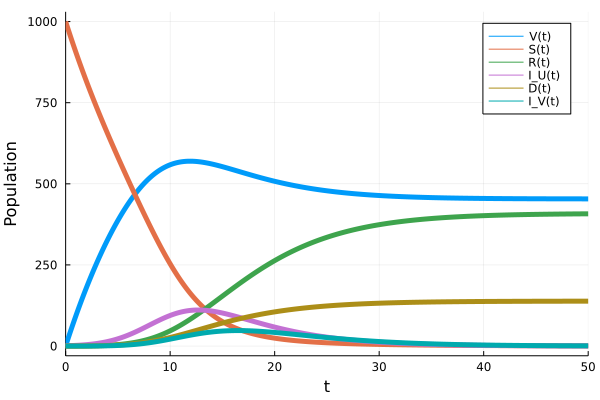

In [8]:
model = get_ptnet(epi_sema)
sol = solution(model, (0.0,50.0))
plot(sol)

## Model stratification

This epidemiological model can be stratified over multiple demographic groups which can cross-infect each other. This takes advantage of the OpenACSet and cospan composition tooling present in Catlab to generate multiple models and compose over states

In [9]:
gen_graph = Semagram{ScaleGraph{Float64, Symbol}}(ScaleGraphSchema)

Semagram{Catlab.CSetDataStructures.AttributedCSet{Catlab.Theories.CatDesc{(:V, :E), (:src, :tgt), (2, 2), (1, 1)}, Catlab.Theories.AttrDesc{Catlab.Theories.CatDesc{(:V, :E), (:src, :tgt), (2, 2), (1, 1)}, (:Scale, :Label), (:crossexposure, :pop_frac, :exposure, :node_label), (2, 1, 1, 1), (1, 1, 1, 2)}, Tuple{Float64, Symbol}, (:src, :tgt), (), Tables, Indices} where {Tables<:NamedTuple, Indices<:NamedTuple}}(WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[], Dict{Symbol, Any}()), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("sending" => (Observable{Dict{String, Any}} with 2 listeners. Value:
Dict{String, Any}("sg" => Dict{String, Any}("gen" => Dict("i" => 0), "boxes" => Tuple{Int64, Dict{_A, _B} where {_A, _B}}[], "schema" => Dict{String, Dict{Symbol, V} where V}("box_types" => Dict{Symbol, BoxProperties}(:V => BoxProperties(Tuple{AttributeType, Symbol}[(Numeric, :pop_frac), (Numeric, :exposure), (Stringlike, :node_label)], "<circle r=\"40\"></circle>", :node_label)), "wire_types" => Dict{Symbol, WireProperties}(:E => WireProperties(Tuple{AttributeType, Symbol}[(Numeric, :crossexposure)], ("Box", :V), :src, ("Box", :V), :tgt, "DefaultWire")), "port_types" => Dict{Symbol, PortProperties}()), "wires" => Tuple{Int64, Dict{_A, _B} where {_A, _B}}[]), "boxlocs" => Tuple{Int64, Tuple{Float64, Float64}}[]), nothing), "receiving" => (Observable{Dict{String, Any}} with 0 listeners. Value:
Dict{String, Any}("sg" => Dict{String, Any}("gen" => Dict("i" => 0), "boxes" => Tuple{Int64, Dict{_A, _B} where {_A, _B}}[], "schema" => Dict{String, Dict{Symbol, V} where V}("box_types" => Dict{Symbol, BoxProperties}(:V => BoxProperties(Tuple{AttributeType, Symbol}[(Numeric, :pop_frac), (Numeric, :exposure), (Stringlike, :node_label)], "<circle r=\"40\"></circle>", :node_label)), "wire_types" => Dict{Symbol, WireProperties}(:E => WireProperties(Tuple{AttributeType, Symbol}[(Numeric, :crossexposure)], ("Box", :V), :src, ("Box", :V), :tgt, "DefaultWire")), "port_types" => Dict{Symbol, PortProperties}()), "wires" => Tuple{Int64, Dict{_A, _B} where {_A, _B}}[]), "boxlocs" => Tuple{Int64, Tuple{Float64, Float64}}[]), nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "semagrams", "/Users/abaas3/.julia/packages/Semagrams/71R02/src/../deps/bundles/app.bundle.js")], Dict{Any, Any}("sending" => Any[WebIO.JSString("(function (newls){console.log(this); return this.state.resetWith(newls)})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x000000015fa85660, Task (runnable) @0x000000015fa85660), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("(function (){var semagrams=System.registry.get(System.resolveSync(\"semagrams\")); var scopeobj=this; return setTimeout((function (){return semagrams.main(WebIO.getval({\"name\":\"receiving\",\"scope\":\"13087986854712299144\",\"id\":\"11230937679843102251\",\"type\":\"observable\"}),scopeobj,(function (x){return WebIO.setval({\"name\":\"receiving\",\"scope\":\"13087986854712299144\",\"id\":\"11230937679843102251\",\"type\":\"observable\"},x)}))}),20)})")]), Observable{Dict{String, Any}} with 0 listeners. Value:
Dict{String, Any}("sg" => Dict{String, Any}("gen" => Dict("i" => 0), "boxes" => Tuple{Int64, Dict{_A, _B} where {_A, _B}}[], "schema" => Dict{String, Dict{Symbol, V} where V}("box_types" => Dict{Symbol, BoxProperties}(:V => BoxProperties(Tuple{AttributeType, Symbol}[(Numeric, :pop_frac), (Numeric, :exposure), (Stringlike, :node_label)], "<circle r=\"40\"></circle>", :node_label)), "wire_types" => Dict{Symbol, WireProperties}(:E => WireProperties(Tuple{AttributeType, Symbol}[(Numeric, :crossexposure)], ("Box", :V), :src, ("Box", :V), :tgt, "DefaultWire")), "port_types" => Dict{Symbol, PortProperties}()), "wires" => Tuple{Int64, Dict{_A, _B} where {_A, _B}}[]), "boxlocs" => Tuple{Int64, Tuple{Float64, Float64}}[]), Observable{Dict{String, Any}} with 2 listeners. Value:


In [10]:
load(gen_graph, "gen_graph.sema");

In [11]:
epi_model = get_ptnet(epi_sema)
generations = get_acset(gen_graph)
strat_model = ModelStratify.dem_strat(model, generations);

### UWD visualization of the composition pattern for this system

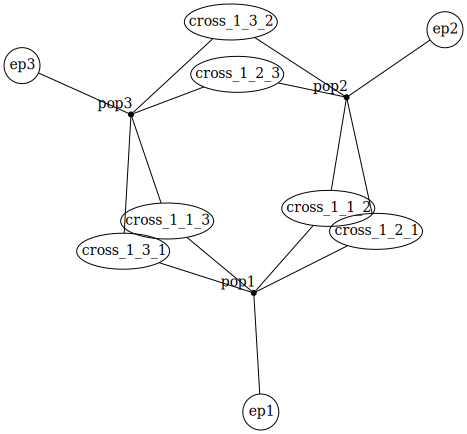

In [34]:
to_graphviz(dem_strat_uwd(model, generations)[1], junction_labels=:variable, box_labels=:name, edge_attrs = Dict(:len => "1.5"))

In [39]:
dem_strat_uwd(model, generations)[2][:ep1] |> apex |> Graph |> show_graph

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.48.0 (20210717.1556)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- s1 -->
 
 s1 
 
 V@Workers 
 
<!-- t3 -->
 
 t3 
 
 β_{UV}@Workers 
 
<!-- s1->t3 -->
 
 s1->t3 
 
 
 1 
 
<!-- t5 -->
 
 t5 
 
 β_{VV}@Workers 
 
<!-- s1->t5 -->
 
 s1->t5 
 
 
 1 
 
<!-- s2 -->
 
 s2 
 
 S@Workers 
 
<!-- t1 -->
 
 t1 
 
 ν@Workers 
 
<!-- s2->t1 -->
 
 s2->t1 
 
 
 1 
 
<!-- t4 -->
 
 t4 
 
 β_{VU}@Workers 
 
<!-- s2->t4 -->
 
 s2->t4 
 
 
 1 
 
<!-- t9 -->
 
 t9 
 
 β_{UU}@Workers 
 
<!-- s2->t9 -->
 
 s2->t9 
 
 
 1 
 
<!-- s3 -->
 
 s3 
 
 R@Workers 
 
<!-- s4 -->
 
 s4 
 
 I_U@Workers 
 
<!-- t2 -->
 
 t2 
 
 δ_U@Workers 
 
<!-- s4->t2 -->
 
 s4->t2 
 
 
 1 
 
<!-- s4->t3 -->
 
 s4->t3 
 
 
 1 
 
<!-- t7 -->
 
 t7 
 
 γ_U@Workers 
 
<!-- s4->t7 -->
 
 s4->t7 
 
 
 1 
 
<!-- s4->t9 -->
 
 s4->t9 
 
 
 1 
 
<!-- s5 -->
 
 s5 
 
 D@Workers 
 
<!-- s6 -->
 
 s6 
 
 I_V@Workers 
 
<!-- s6->t4 -->
 
 s6->t4 
 
 
 1 
 
<!-- s6->t5 -->
 
 s6->t5 
 
 
 1 
 
<!-- t6 -->
 
 t6 
 
 δ_V@Workers 
 
<!-- s6->t6 -->
 
 s6->t6 
 
 
 1 
 
<!-- t8 -->
 
 t8 
 
 γ_V@Workers 
 
<!-- s6->t8 -->
 
 s6->t8 
 
 
 1 
 
<!-- t1->s1 -->
 
 t1->s1 
 
 
 1 
 
<!-- t2->s5 -->
 
 t2->s5 
 
 
 1 
 
<!-- t3->s4 -->
 
 t3->s4 
 
 
 1 
 
<!-- t3->s6 -->
 
 t3->s6 
 
 
 1 
 
<!-- t4->s4 -->
 
 t4->s4 
 
 
 1 
 
<!-- t4->s6 -->
 
 t4->s6 
 
 
 1 
 
<!-- t5->s6 -->
 
 t5->s6 
 
 
 2 
 
<!-- t6->s5 -->
 
 t6->s5 
 
 
 1 
 
<!-- t7->s3 -->
 
 t7->s3 
 
 
 1 
 
<!-- t8->s3 -->
 
 t8->s3 
 
 
 1 
 
<!-- t9->s4 -->
 
 t9->s4 
 
 
 2

### Evaluation of the composition over sub-models

In [12]:
str_loc = ModelStratify.strat_location(strat_model, epi_model, generations, 
                                       locations(epi_model, save(epi_sema), scale=144 * 0.4), 
                                       locations(generations, save(gen_graph)), scale=1.4);

show_graph(Graph(strat_model, positions=str_loc))

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.48.0 (20210717.1556)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- s1 -->
 
 s1 
 
 V@Workers 
 
<!-- t3 -->
 
 t3 
 
 β_{UV}@Workers 
 
<!-- s1->t3 -->
 
 s1->t3 
 
 
 1 
 
<!-- t5 -->
 
 t5 
 
 β_{VV}@Workers 
 
<!-- s1->t5 -->
 
 s1->t5 
 
 
 1 
 
<!-- t44 -->
 
 t44 
 
 crx_V′_I_U_2_1 
 
<!-- s1->t44 -->
 
 s1->t44 
 
 
 1 
 
<!-- t46 -->
 
 t46 
 
 crx_V′_I_V_2_1 
 
<!-- s1->t46 -->
 
 s1->t46 
 
 
 1 
 
<!-- t48 -->
 
 t48 
 
 crx_V′_I_U_3_1 
 
<!-- s1->t48 -->
 
 s1->t48 
 
 
 1 
 
<!-- t50 -->
 
 t50 
 
 crx_V′_I_V_3_1 
 
<!-- s1->t50 -->
 
 s1->t50 
 
 
 1 
 
<!-- s2 -->
 
 s2 
 
 S@Workers 
 
<!-- t1 -->
 
 t1 
 
 ν@Workers 
 
<!-- s2->t1 -->
 
 s2->t1 
 
 
 1 
 
<!-- t4 -->
 
 t4 
 
 β_{VU}@Workers 
 
<!-- s2->t4 -->
 
 s2->t4 
 
 
 1 
 
<!-- t9 -->
 
 t9 
 
 β_{UU}@Workers 
 
<!-- s2->t9 -->
 
 s2->t9 
 
 
 1 
 
<!-- t45 -->
 
 t45 
 
 crx_S′_I_V_2_1 
 
<!-- s2->t45 -->
 
 s2->t45 
 
 
 1 
 
<!-- t47 -->
 
 t47 
 
 crx_S′_I_U_2_1 
 
<!-- s2->t47 -->
 
 s2->t47 
 
 
 1 
 
<!-- t49 -->
 
 t49 
 
 crx_S′_I_V_3_1 
 
<!-- s2->t49 -->
 
 s2->t49 
 
 
 1 
 
<!-- t51 -->
 
 t51 
 
 crx_S′_I_U_3_1 
 
<!-- s2->t51 -->
 
 s2->t51 
 
 
 1 
 
<!-- s3 -->
 
 s3 
 
 R@Workers 
 
<!-- s4 -->
 
 s4 
 
 I_U@Workers 
 
<!-- t2 -->
 
 t2 
 
 δ_U@Workers 
 
<!-- s4->t2 -->
 
 s4->t2 
 
 
 1 
 
<!-- s4->t3 -->
 
 s4->t3 
 
 
 1 
 
<!-- t7 -->
 
 t7 
 
 γ_U@Workers 
 
<!-- s4->t7 -->
 
 s4->t7 
 
 
 1 
 
<!-- s4->t9 -->
 
 s4->t9 
 
 
 1 
 
<!-- t32 -->
 
 t32 
 
 crx_V′_I_U_1_3 
 
<!-- s4->t32 -->
 
 s4->t32 
 
 
 1 
 
<!-- t35 -->
 
 t35 
 
 crx_S′_I_U_1_3 
 
<!-- s4->t35 -->
 
 s4->t35 
 
 
 1 
 
<!-- t40 -->
 
 t40 
 
 crx_V′_I_U_1_2 
 
<!-- s4->t40 -->
 
 s4->t40 
 
 
 1 
 
<!-- t43 -->
 
 t43 
 
 crx_S′_I_U_1_2 
 
<!-- s4->t43 -->
 
 s4->t43 
 
 
 1 
 
<!-- s5 -->
 
 s5 
 
 D@Workers 
 
<!-- s6 -->
 
 s6 
 
 I_V@Workers 
 
<!-- s6->t4 -->
 
 s6->t4 
 
 
 1 
 
<!-- s6->t5 -->
 
 s6->t5 
 
 
 1 
 
<!-- t6 -->
 
 t6 
 
 δ_V@Workers 
 
<!-- s6->t6 -->
 
 s6->t6 
 
 
 1 
 
<!-- t8 -->
 
 t8 
 
 γ_V@Workers 
 
<!-- s6->t8 -->
 
 s6->t8 
 
 
 1 
 
<!-- t33 -->
 
 t33 
 
 crx_S′_I_V_1_3 
 
<!-- s6->t33 -->
 
 s6->t33 
 
 
 1 
 
<!-- t34 -->
 
 t34 
 
 crx_V′_I_V_1_3 
 
<!-- s6->t34 -->
 
 s6->t34 
 
 
 1 
 
<!-- t41 -->
 
 t41 
 
 crx_S′_I_V_1_2 
 
<!-- s6->t41 -->
 
 s6->t41 
 
 
 1 
 
<!-- t42 -->
 
 t42 
 
 crx_V′_I_V_1_2 
 
<!-- s6->t42 -->
 
 s6->t42 
 
 
 1 
 
<!-- s7 -->
 
 s7 
 
 V@Retirees 
 
<!-- t12 -->
 
 t12 
 
 β_{UV}@Retirees 
 
<!-- s7->t12 -->
 
 s7->t12 
 
 
 1 
 
<!-- t14 -->
 
 t14 
 
 β_{VV}@Retirees 
 
<!-- s7->t14 -->
 
 s7->t14 
 
 
 1 
 
<!-- t28 -->
 
 t28 
 
 crx_V′_I_U_3_2 
 
<!-- s7->t28 -->
 
 s7->t28 
 
 
 1 
 
<!-- t30 -->
 
 t30 
 
 crx_V′_I_V_3_2 
 
<!-- s7->t30 -->
 
 s7->t30 
 
 
 1 
 
<!-- s7->t40 -->
 
 s7->t40 
 
 
 1 
 
<!-- s7->t42 -->
 
 s7->t42 
 
 
 1 
 
<!-- s8 -->
 
 s8 
 
 S@Retirees 
 
<!-- t10 -->
 
 t10 
 
 ν@Retirees 
 
<!-- s8->t10 -->
 
 s8->t10 
 
 
 1 
 
<!-- t13 -->
 
 t13 
 
 β_{VU}@Retirees 
 
<!-- s8->t13 -->
 
 s8->t13 
 
 
 1 
 
<!-- t18 -->
 
 t18 
 
 β_{UU}@Retirees 
 
<!-- s8->t18 -->
 
 s8->t18 
 
 
 1 
 
<!-- t29 -->
 
 t29 
 
 crx_S′_I_V_3_2 
 
<!-- s8->t29 -->
 
 s8->t29 
 
 
 1 
 
<!-- t31 -->
 
 t31 
 
 crx_S′_I_U_3_2 
 
<!-- s8->t31 -->
 
 s8->t31 
 
 
 1 
 
<!-- s8->t41 -->
 
 s8->t41 
 
 
 1 
 
<!-- s8->t43 -->
 
 s8->t43 
 
 
 1 
 
<!-- s9 -->
 
 s9 
 
 R@Retirees 
 
<!-- s10 -->
 
 s10 
 
 I_U@Retirees 
 
<!-- t11 -->
 
 t11 
 
 δ_U@Retirees 
 
<!-- s10->t11 -->
 
 s10->t11 
 
 
 1 
 
<!-- s10->t12 -->
 
 s10->t12 
 
 
 1 
 
<!-- t16 -->
 
 t16 
 
 γ_U@Retirees 
 
<!-- s10->t16 -->
 
 s10->t16 
 
 
 1 
 
<!-- s10->t18 -->
 
 s10->t18 
 
 
 1 
 
<!-- t36 -->
 
 t36 
 
 crx_V′_I_U_2_3 
 
<!-- s10->t36 -->
 
 s10->t36 
 
 
 1 
 
<!-- t39 -->
 
 t39 
 
 crx_S′_I_U_2_3 
 
<!-- s10-

In [44]:
strat_sema = Semagram(strat_model; positions=str_loc, scale=0.7)

Semagram{Catlab.CSetDataStructures.AttributedCSet{Catlab.Theories.CatDesc{(:T, :S, :I, :O), (:it, :is, :ot, :os), (3, 3, 4, 4), (1, 2, 1, 2)}, Catlab.Theories.AttrDesc{Catlab.Theories.CatDesc{(:T, :S, :I, :O), (:it, :is, :ot, :os), (3, 3, 4, 4), (1, 2, 1, 2)}, (:Rate, :Concentration, :Name), (:rate, :concentration, :tname, :sname), (1, 2, 1, 2), (1, 2, 3, 3)}, Tuple{Union{Float64, Function, String}, Float64, Symbol}, (:is, :it, :os, :ot), (), NamedTuple{(:T, :S, :I, :O), Tuple{TypedTables.Table{NamedTuple{(:rate, :tname), Tuple{Union{Float64, Function, String}, Symbol}}, 1, NamedTuple{(:rate, :tname), Tuple{Vector{Union{Float64, Function, String}}, Vector{Symbol}}}}, TypedTables.Table{NamedTuple{(:concentration, :sname), Tuple{Float64, Symbol}}, 1, NamedTuple{(:concentration, :sname), Tuple{Vector{Float64}, Vector{Symbol}}}}, TypedTables.Table{NamedTuple{(:it, :is), Tuple{Int64, Int64}}, 1, NamedTuple{(:it, :is), Tuple{Vector{Int64}, Vector{Int64}}}}, TypedTables.Table{NamedTuple{(:ot, :os), Tuple{Int64, Int64}}, 1, NamedTuple{(:ot, :os), Tuple{Vector{Int64}, Vector{Int64}}}}}}, NamedTuple{(:is, :it, :os, :ot), NTuple{4, Vector{Vector{Int64}}}}}}(WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[], Dict{Symbol, Any}()), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("sending" => (Observable{Dict{String, Any}} with 2 listeners. Value:
Dict{String, Any}("sg" => Dict{String, Any}("gen" => Dict("i" => 243), "boxes" => Tuple{Int64, Dict{String, Any}}[(5, Dict("weights" => Dict(:tname => "δ_V@Workers", :rate => "0.01"), "ty" => :T, "ports" => Tuple{Int64, Dict{_A, _B} where {_A, _B}}[])), (56, Dict("weights" => Dict(:sname => "I_V@Workers", :concentration => "0.0"), "ty" => :S, "ports" => Tuple{Int64, Dict{_A, _B} where {_A, _B}}[])), (16, Dict("weights" => Dict(:tname => "γ_V@Retirees", :rate => "0.3"), "ty" => :T, "ports" => Tuple{Int64, Dict{_A, _B} where {_A, _B}}[])), (20, Dict("weights" => Dict(:tname => "β_{UV}@School", :rate => "0.00039439952672056796"), "ty" => :T, "ports" => Tuple{Int64, Dict{_A, _B} where {_A, _B}}[])), (35, Dict("weights" => Dict(:tname => "crx_V′_I_U_2_3", :rate => "3.94399526720568e-6"), "ty" => :T, "ports" => Tuple{Int64, Dict{_A, _B} where {_A, _B}}[])), (55, Dict("weights" => Dict(:sname => "D@Workers", :concentration => "0.0"), "ty" => :S, "ports" => Tuple{Int64, Dict{_A, _B} where {_A, _B}}[])), (60, Dict("weights" => Dict(:sname => "I_U@Retirees", :concentration => "0.2"), "ty" => :S, "ports" => Tuple{Int64, Dict{_A, _B} where {_A, _B}}[])), (30, Dict("weights" => Dict(:tname => "crx_S′_I_U_3_2", :rate => "1.9719976336028397e-5"), "ty" => :T, "ports" => Tuple{Int64, Dict{_A, _B} where {_A, _B}}[])), (19, Dict("weights" => Dict(:tname => "δ_U@School", :rate => "0.08"), "ty" => :T, "ports" => Tuple{Int64, Dict{_A, _B} where {_A, _B}}[])), (0, Dict("weights" => Dict(:tname => "ν@Workers", :rate => "0.1"), "ty" => :T, "ports" => Tuple{Int64, Dict{_A, _B} where {_A, _B}}[]))  …  (50, Dict("weights" => Dict(:tname => "crx_S′_I_U_3_1", :rate => "0.00098599881680142"), "ty" => :T, "ports" => Tuple{Int64, Dict{_A, _B} where {_A, _B}}[])), (15, Dict("weights" => Dict(:tname => "γ_U@Retirees", :rate => "0.1"), "ty" => :T, "ports" => Tuple{Int64, Dict{_A, _B} where {_A, _B}}[])), (59, Dict("weights" => Dict(:sname => "R@Retirees", :concentration => "0.0"), "ty" => :S, "ports" => Tuple{Int64, Dict{_A, _B} where {_A, _B}}[])), (2, Dict("weights" => Dict(:tname => "β_{UV}@Workers", :rate => "0.00039439952672056796"), "ty" => :T, "ports" => Tuple{Int64, Dict{_A, _B} where {_A, _B}}[])), (10, Dict("weights" => Dict(:tname => "δ_U@Retirees", :rate => "0.08"), "ty" => :T, "ports" => Tuple{Int64, Dict{_A, _B} where {_A, _B}}[])), (18, Dict("weights" => Dict(:tname => "ν@School", :rate => "0.1"), "ty" => :T, "ports" => Tuple{Int64, Dict{_A, _B} where {_A, _B}}[])), (26, Dict("weights" => Dict(:tname => "β_{UU}@School", :rate => "0.00197199763360284"), "ty" => :T, "ports" => Tupl

In [46]:
strat_model[:δ_V, :School] *= 0.1
strat_model[:δ_U, :School] *= 0.1
strat_model[:δ_V, :Retirees] *= 1.5
strat_model[:δ_U, :Retirees] *= 1.5

strat_model[:I_U, :Retirees] = 0.0
strat_model[:I_U, :School] = 0.0;

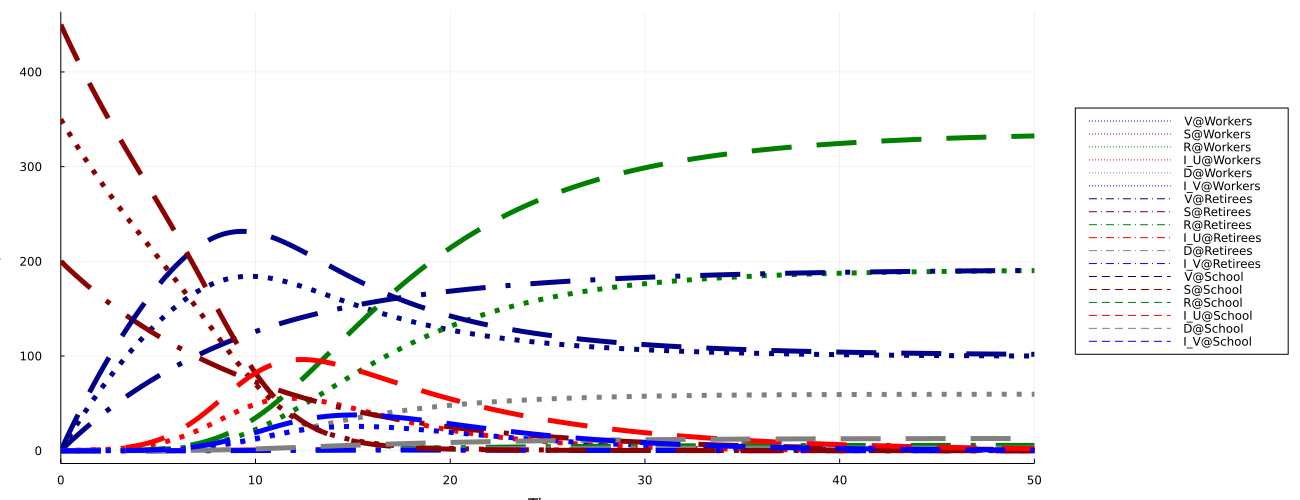

In [47]:
tspan = (0.0, 50.0)
sol = solution(strat_model, tspan)
linestyles = Dict("School"=>:dash, "Retirees"=>:dashdot, "Workers"=>:dot)
linecolors = Dict("S"=>:darkred, "V"=>:darkblue, "I_U"=>:red, "I_V"=>:blue, "R"=>:green, "D"=>:gray)
times = range(tspan..., length=1000)

states = ["V", "I_U", "I_V", "D", "R", "S"]
pops = ["School", "Retirees", "Workers"]
names = filter(s ->first(split("$s", "@")) ∈ states && last(split("$s", "@")) ∈ pops,  snames(strat_model))
plot(times, hcat(collect([sol(t)[n] for t in times] for n in names)...); linestyle=reshape([linestyles[last(split("$s", "@"))] for s in names], (1,length(names))),
          color=reshape([linecolors[first(split("$s", "@"))] for s in names], (1,length(names))), labels=reshape(string.(names), (1,length(names))), legend=:outerright, size=(1.3e3,5e2), xrange=tspan)